In [1]:
import h5py
import numpy as np
import ROOT as r

Welcome to JupyROOT 6.24/07


In [1]:
import matplotlib.pyplot as plt

In [3]:
%jsroot on

In [4]:
import tqdm

In [5]:
SIGNAL_PDG_ID = 1000006
MAX_ETA = 2.3
N_JET_MAX = 12
N_FEAT = 14
N_PART_PER_JET = 10
DELTA_R_MATCH = 0.4

r.gROOT.SetBatch(1)

In [6]:
inFile = r.TFile.Open("root://cmsxrootd.fnal.gov///store/user/aaportel/john_files/DisplacedSUSY_stopToBottom_M_800_500mm_TuneCP5_14TeV_pythia8/RespNtuple_DisplacedSUSY_stopToBottom_M_800_500mm_TuneCP5_14TeV_pythia8/220404_193558/0000/pfTuple_100.root", "READ")

In [8]:
#inFile = r.TFile.Open("root://cmseos.fnal.gov///store/user/mequinna/file4russell_2.root", "READ")

In [9]:
 tree = inFile.Get("ntuple0/objects")

In [10]:
 ver = inFile.Get("ntuple0/objects/vz")

In [11]:
tree.Show(167) #tree has 168 events (branches are below). Below is the last branch (when [0, 168))

======> EVENT:167
 emcalo          = (vector<pair<TLorentzVector,int> >*)0xa990cf0
 egcalo          = (vector<pair<TLorentzVector,int> >*)0x9721b30
 calo            = (vector<pair<TLorentzVector,int> >*)0xa994990
 pf              = (vector<pair<TLorentzVector,int> >*)0xa98c3a0
 pup             = (vector<pair<TLorentzVector,int> >*)0xa9cc9e0
 gen             = (vector<pair<TLorentzVector,int> >*)0xa9cef10
 l1jet           = (vector<pair<TLorentzVector,int> >*)0x8752730
 recojet         = (vector<pair<TLorentzVector,int> >*)0xa9ceca0
 pf_vx           = (vector<float>*)0xa9a0130
 pf_vy           = (vector<float>*)0x3c33220
 pf_vz           = (vector<float>*)0xa9dbbe0
 pup_vx          = (vector<float>*)0xa9fb5b0
 pup_vy          = (vector<float>*)0xa9aaeb0
 pup_vz          = (vector<float>*)0xa986f40
 vz              = (vector<float>*)0x985e050


In [12]:
eventNum = tree.GetEntries()
ptCut = 30
jetNum = 0
signalPartCount = 0
jetPartList = []
trainArray = []
testArray = []
jetFullData = []
trainingFullData = []

In [13]:
eventNum

40708

In [14]:
def scalePartType(a, n):
    if n == 11:
        a.extend((1, 0, 0, 0, 0, 0, 0, 0))  # Electron
    elif n == -11:
        a.extend((0, 1, 0, 0, 0, 0, 0, 0))  # Positron
    elif n == 13:
        a.extend((0, 0, 1, 0, 0, 0, 0, 0))  # Muon
    elif n == -13:
        a.extend((0, 0, 0, 1, 0, 0, 0, 0))  # Anti-Muon
    elif n == 22:
        a.extend((0, 0, 0, 0, 1, 0, 0, 0))  # Photon
    elif n == 130:
        a.extend((0, 0, 0, 0, 0, 1, 0, 0))  # Neutral Meson
    elif n == 211:
        a.extend((0, 0, 0, 0, 0, 0, 1, 0))  # Pion
    elif n == -211:
        a.extend((0, 0, 0, 0, 0, 0, 0, 1))  # Anti-Pion
    else:
        a.extend((0, 0, 0, 0, 0, 0, 0, 0))  # Case for unknown particle

In [15]:
def signedDeltaPhi(phi1, phi2):
    dPhi = phi1 - phi2
    if dPhi < -np.pi:
        dPhi = 2 * np.pi + dPhi
    elif dPhi > np.pi:
        dPhi = -2 * np.pi + dPhi
    return dPhi

In [16]:
jetPartsArray = []
jetDataArray = []

In [17]:
eventNum

40708

In [18]:
 pbar = tqdm.tqdm(range(eventNum))

  0%|                                                 | 0/40708 [00:00<?, ?it/s]

In [20]:
partType = []

In [21]:
for entryNum in pbar: #pbar = 168 events
    #if entryNum == 10000: break
    #if (entryNum > 0):
    #    print(entryNum)
    #   break
    #print(entryNum)
    #pbar.set_description("Jets: " + str(len(jetPartsArray)) + "; Signal Jets: " + str(signalPartCount))
    #print("Entries in the the event: ", tree.GetEntry(entryNum) ) #------>
    tree.GetEntry(entryNum)
    ver = tree.vz
    obj = tree.pf
    g = tree.gen
    #print(len(g), entryNum)
    verPf = tree.pf_vz
    verPfX = tree.pf_vx
    verPfY = tree.pf_vy
    jetNum = 0
    
    bannedParts = []  # List of indices of particles that have already been used by previous jets
    bannedSignalParts = []  # Same deal but with indices within the gen tree corresponding to signal gen particle
    
  
    for i in range(len(obj)):
        partType.append(obj[i][1])
        jetPartList = []
        seedParticle = []
        if jetNum >= N_JET_MAX:  # Limited to 12 jets per event at maximum
            jetNum = 0
            break
        
        if i not in bannedParts:  # Identifies highest avaiable pT particle to use as seed
            tempTLV = obj[i][0]  # Takes TLorentzVector of seed particle to use for jet reconstruction
            scalePartType(seedParticle, abs(obj[i][1]))  # One-Hot Encoding Seed Particle Type
            
            
            #I guess for particle 22 and 130, the particle dZ is 0.
            if obj[i][1] in [22, 130]:
                seedParticle.extend(
                    [
                        0.0,
                        verPfX[i],
                        verPfY[i],
                        obj[i][0].Pt(),
                        obj[i][0].Eta(),
                        obj[i][0].Phi(),
                      
                    ]
                )  # Add in dZ, dX, dY, Particle Pt, Eta, & Phi, last 3 features to be scaled later
            else:
                seedParticle.extend(
                    [
                        ver[0] - verPf[i],
                        verPfX[i],
                        verPfY[i],
                        obj[i][0].Pt(),
                        obj[i][0].Eta(),
                        obj[i][0].Phi(),
                    
                    ]) # Add in dZ, dX, dY, Particle Pt, Eta, & Phi, last 3 features to be scaled later
            jetPartList.extend(seedParticle)
            #print(jetPartList) #-------->
            #print("[ One-Hot encoding (7 indices), dZ, dX, dY, Pt Eta, Phi ]") #---------->
            bannedParts.append(i)
            #print(bannedParts) #------->
            for j in range(len(obj)):
                #if j > 0:
                #    print(j) # ----->
                #    break
                partFts = []
                
                #Below, if new particle within Delta R = 0.4, add T-Lorentz vectors
                if (
                        obj[i][0].DeltaR(obj[j][0]) <= DELTA_R_MATCH and i != j and (j not in bannedParts)
                    ):  # Look for available particles within deltaR<0.4 of seed particle
                    
                    #print( obj[i][0].DeltaR(obj[j][0])) ## ??? not printing 
                    #print(DELTA_R_MATCH) #------>
                    tempTLV = tempTLV + obj[j][0]  # Add to tempTLV
    
                    scalePartType(partFts, obj[j][1])  # One-Hot Encoding of this new Particle Type
        
                    
                    if obj[j][1] == 22 or obj[j][1] == 130: #Check if it's those pdg part ID
                            partFts.extend(
                                [
                                    0.0,
                                    verPfX[j],
                                    verPfY[j],
                                    obj[j][0].Pt(),
                                    obj[j][0].Eta(),
                                    obj[j][0].Phi(),
                                ]
                            )  # Add in dZ, dX, dY, Particle Pt, Eta, & Phi, last 3 features to be scaled later
                    else:
                        partFts.extend(
                            [
                                ver[0] - verPf[j],
                                verPfX[j],
                                verPfY[j],
                                obj[j][0].Pt(),
                                obj[j][0].Eta(),
                                obj[j][0].Phi(),
                            ]
                        )
                jetPartList.extend(partFts)  # Add particle features to particle list
                #print(jetPartList)  #------------>
                bannedParts.append(j)  # Mark this particle as unavailable for other jets
                #print(bannedParts) #----------->
                #print("length of jets particle list:", len(jetPartList) )#---->
                #print("------------------")# ------->
                if (
                        len(jetPartList) >= N_PART_PER_JET * N_FEAT
                    ):  # If you reach 10 particles in one jet, break and move on
                    break
                if abs(tempTLV.Pt()) < ptCut:  # Neglect to save jet if it falls below pT Cut
                    break
                    
                 # Scaling particle pT, Eta, and Phi based on jet pT, Eta, and Phi
                c = N_PART_PER_JET + 1
                while c < len(jetPartList) - 2:
                    jetPartList[c] = jetPartList[c] / tempTLV.Pt()
                    jetPartList[c + 1] = tempTLV.Eta() - jetPartList[c + 1]
                    tempPhi = jetPartList[c + 2]
                    jetPartList[c + 2] = signedDeltaPhi(tempTLV.Phi(), tempPhi)
                    c += N_FEAT # move on to next particle in the jet
                
                while len(jetPartList) < N_PART_PER_JET * N_FEAT:
                    jetPartList.append(0)
                    
                jetPartList.append(0)    
                for e in range(len(tree.gen)):
                    #print(e)
                    if (
                    abs(tree.gen[e][1]) == SIGNAL_PDG_ID
                    and (e not in bannedSignalParts)
                    and abs(tree.gen[e][0].Eta()) < MAX_ETA
                    ):
                        if tree.gen[e][0].DeltaR(tempTLV) <= DELTA_R_MATCH:
                            jetPartList[-1] = 1
                            signalPartCount += 1
                            s = 1
                            bannedSignalParts.append(e)
                            break
                    else: s = 0 
                            
                jetPartsArray.append(jetPartList)
                jetDataArray.append((tempTLV.Pt(), tempTLV.Eta(), tempTLV.Phi(), tempTLV.M(),  jetPartList[-1]))
                
                

 25%|████████▌                          | 10000/40708 [24:52<1:16:24,  6.70it/s]


[One hot encoding, part #       \][dz, dx,   dy,  pt,        eta           ,     phi]


In [16]:
len(tree.gen)

2

In [45]:
range(eventNum)

range(0, 50000)

In [70]:
for e in range(len(tree.gen)):
    print(tree.gen[e][1])

1000006
-1000006


In [69]:
len(tree.pf)

318

In [2]:
import pandas as pd

In [4]:
parts = pd.Series(partType)

In [24]:
parts.value_counts()

 130    1154191
 211     819929
-211     797958
 22      219247
 11       21870
-11       20612
 13        1653
-13        1540
dtype: int64

Text(0.5, 0, 'counts')

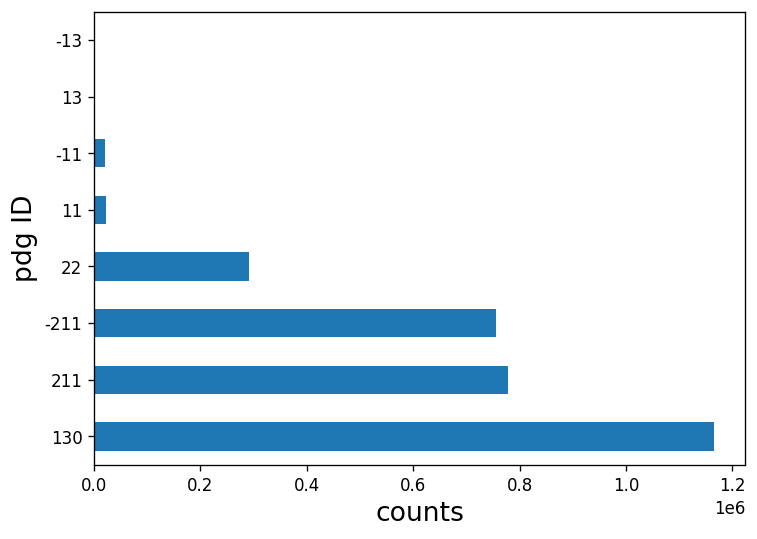

In [70]:
plt.figure(figsize=(7,5), dpi=120)
parts.value_counts().plot(kind="barh")
plt.ylabel("pdg ID", fontsize=16)
plt.xlabel("counts", fontsize=16)

From QCD

Text(0.5, 0, 'counts')

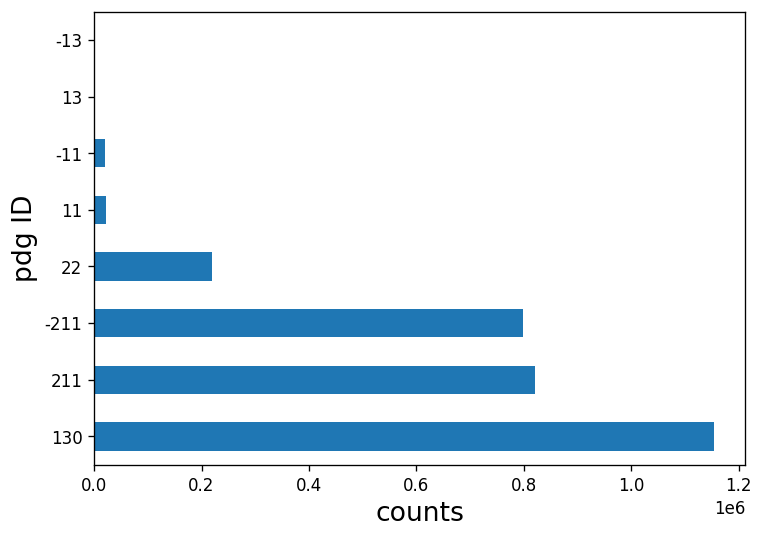

In [25]:
plt.figure(figsize=(7,5), dpi=120)
parts.value_counts().plot(kind="barh")
plt.ylabel("pdg ID", fontsize=16)
plt.xlabel("counts", fontsize=16)

In [58]:
signalPartCount

64

In [59]:
len(obj)

318

In [63]:
len(tree.gen)

2

In [54]:
len(jetPartsArray[17])

166

In [56]:
len(jetPartsArray[17])

166

In [ ]:
[l[2:4] for l in infoL[:]]

In [42]:
len(jetPartsArray[17])

166

In [84]:
#jetPartsArray[0]

In [49]:
len(jetPartsArray[2])

141

In [101]:
for e in range(len(tree.gen)):
    print(e)
    if (
    abs(tree.gen[e][1]) == SIGNAL_PDG_ID
    and (e not in bannedSignalParts)
    and abs(tree.gen[e][0].Eta()) < MAX_ETA
    ):
        if tree.gen[e][0].DeltaR(tempTLV) <= DELTA_R_MATCH:
            jetPartList[-1] = 1
            signalPartCount += 1
            bannedSignalParts.append(e)
            break

0
1


In [102]:
signalPartCount

0

In [85]:
 bannedSignalParts

[]

In [ ]:
obj[0][0].DeltaR([0][0])

In [ ]:
obj

In [1]:
 tree.GetEntry(0)

NameError: name 'tree' is not defined

In [19]:
obj = tree.pup

In [20]:
len(obj)

38